# Gene Modulation Example
The goal of this notebook is to illustrate basic usage of I/O functionality in the [`cmapR`](https://github.com/cmap/cmapR) package. As a case study, we'll be analyzing signatures of compounds that do and do not modulate the gene MYC.

## Setup

In [1]:
# load cmapR library
library(cmapR)

# load data.table for fast reading of text files
library(data.table)

# load pheatmap for plotting heatmaps
suppressWarnings(library(pheatmap))

Set up paths for matrix and metadata. Adjust these as needed.

In [21]:
ds_path <- "/srv/data/cmap/GSE92742_Broad_LINCS_Level5_COMPZ.MODZ_n473647x12328.gctx"
siginfo_path <- "/srv/data/cmap/GSE92742_Broad_LINCS_sig_info.txt"
sig_metrics_path <- "/srv/data/cmap/GSE92742_Broad_LINCS_sig_metrics.txt"
geneinfo_path <- "/srv/data/cmap/GSE92742_Broad_LINCS_gene_info.txt"

## Slicing

Load the metadata for all CMap signatures. We're doing this because we don't want to load all signatures at once. The matrix is too large. So instead, we'll figure out the specific set of signatures beforehand and then extract only those.

In [22]:
# suppressing warnings so that we don't have to see
# fread complain about inconsistencies in some of the
# metadata columns
siginfo <- suppressWarnings(data.table::fread(siginfo_path))
sigmetrics <- suppressWarnings(data.table::fread(sig_metrics_path))

In [27]:
index <- match(sigmetrics$sig_id, siginfo$sig_id)
sigmetrics$cell_id <- siginfo$cell_id[index]

And for genes

In [28]:
geneinfo <- data.table::fread(geneinfo_path)

Designate my gene of interest using its gene symbol.



In [29]:
my_gene <- "MYC"

Look up the corresponding gene_id, since this will correspond to row ids in the data matrix

In [30]:
my_gene_id <- geneinfo[pr_gene_symbol==my_gene]$pr_gene_id

Figure out list of signature ids (sig_ids) corresponding to compounds in the cell line A375, where the given signature had exactly 3 replicates. This is somewhat arbitrary but useful in reducing the number of signatures we're dealing with.

In [31]:
sigs_of_interest <- sigmetrics[pert_type=="trt_cp" &
                  cell_id=="A375" & 
                  distil_nsample==3]
sig_ids <- sigs_of_interest$sig_id

How many did we get?

In [32]:
length(sig_ids)

[1] 7020

Now slice out the corresponding rows and columns from the data matrix using parse.gctx, which will return an object of class GCT. Make sure to cast the gene_id as a character so it's not mistakenly interpreted as an integer index.

In [33]:
ds <- cmapR::parse.gctx(ds_path,
                        rid=as.character(my_gene_id),
                        cid=sig_ids)

reading /srv/data/cmap/GSE92742_Broad_LINCS_Level5_COMPZ.MODZ_n473647x12328.gctx
done


Let's take a look at the structure of the object we can do this by simply typing its name

In [34]:
ds

Formal class 'GCT' [package "cmapR"] with 7 slots
  ..@ mat    : num [1, 1:7020] 0.0869 -0.5384 -0.6922 0.5781 1.0301 ...
  .. ..- attr(*, "dimnames")=List of 2
  .. .. ..$ : chr "4609"
  .. .. ..$ : chr [1:7020] "CPC004_A375_6H:BRD-A00546892-001-01-8:10" "CPC004_A375_6H:BRD-A00993607-003-15-4:10" "CPC004_A375_6H:BRD-A01593789-001-02-3:10" "CPC004_A375_6H:BRD-A01643550-001-03-1:10" ...
  ..@ rid    : chr "4609"
  ..@ cid    : chr [1:7020] "CPC004_A375_6H:BRD-A00546892-001-01-8:10" "CPC004_A375_6H:BRD-A00993607-003-15-4:10" "CPC004_A375_6H:BRD-A01593789-001-02-3:10" "CPC004_A375_6H:BRD-A01643550-001-03-1:10" ...
  ..@ rdesc  :'data.frame':	1 obs. of  1 variable:
  .. ..$ id: chr "4609"
  ..@ cdesc  :'data.frame':	7020 obs. of  1 variable:
  .. ..$ id: chr [1:7020] "CPC004_A375_6H:BRD-A00546892-001-01-8:10" "CPC004_A375_6H:BRD-A00993607-003-15-4:10" "CPC004_A375_6H:BRD-A01593789-001-02-3:10" "CPC004_A375_6H:BRD-A01643550-001-03-1:10" ...
  ..@ version: chr(0) 
  ..@ src    : chr "/srv/da

Note that the matrix only has one row, because we only requested data for a single gene.

We're interested in the data matrix, located in the slot `@mat`. Let's look at the distribution of z-scores. We'll add some vertical lines to indicate the thresholds for modulation.

## Analysis

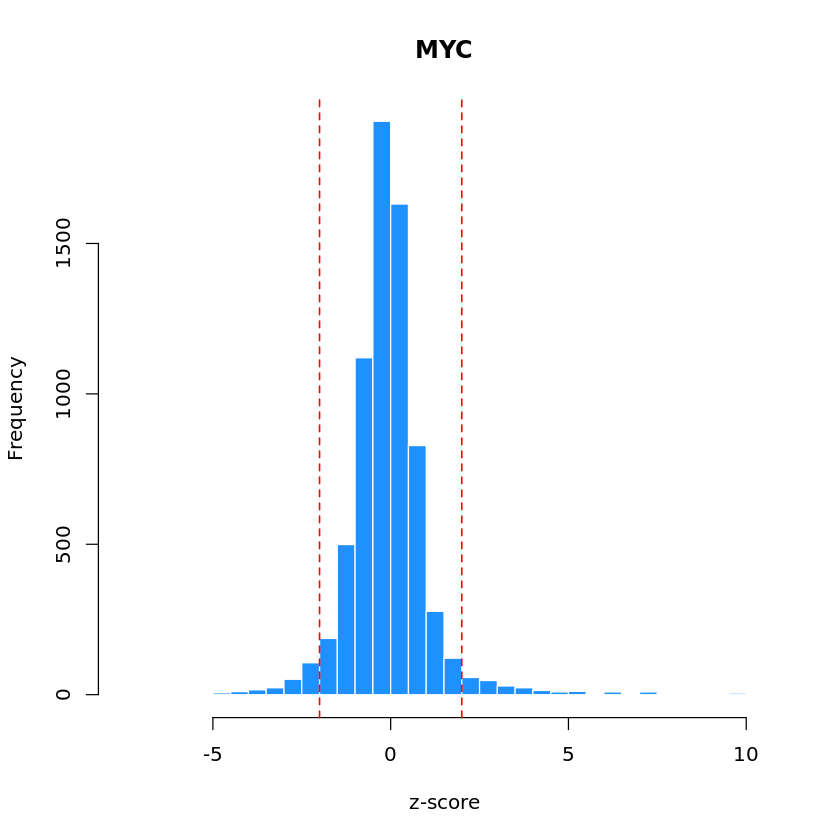

In [35]:
hist(ds@mat, col="dodgerblue", border="white", breaks=30, main=my_gene, xlab="z-score")
abline(v=2, lty=2, col=2, lwd=1.3)
abline(v=-2, lty=2, col=2, lwd=1.3)

Lets identify the signatures in which the gene was significantly modulated.

In [36]:
mod_idx <- which(abs(ds@mat[1, ]) > 2)

How many are there?

In [37]:
length(mod_idx)

[1] 451

Let's compare these signatures to each other to see whether they have any similarity. For comparison, we'll include roughly the same number of signatures in which the gene was **NOT** modulated.

In [38]:
non_mod_idx <- which(abs(ds@mat[1, ]) < 0.06)
length(non_mod_idx)

[1] 456

Good, this is roughly an equal number. Slice out the signatures from the matrix, restricting to landmark space

In [ ]:
lm_ids <- as.character(geneinfo[pr_is_lm==1]$pr_gene_id)
ds2 <- parse.gctx(ds_path, rid=lm_ids,
                  cid=c(names(mod_idx), names(non_mod_idx)))


Compute all pairwise correlations between signatures

In [ ]:
corr <- cor(ds2@mat, method="spearman")

Cluster the correlations, overlaying a color bar indicating the degree of modulation of our gene of interest

In [ ]:
mod_df <- data.frame(zscore=ds@mat[, c(mod_idx, non_mod_idx)])
rownames(mod_df) <- c(names(mod_idx), names(non_mod_idx))

Plot as a heatmap using the `pheatmap` package

In [ ]:
pheatmap::pheatmap(corr, annotation_row=mod_df, annotation_col=mod_df,
                  show_rownames=F, show_colnames=F)

Seems like we do see ~2 clusters which roughly correspond to the signatures in wich our gene is modulated. Not perfect but definitely a trend.